In [ ]:
using Pkg
# environmentName will be used several times in this notebook
environmentName = "02-networks"
Pkg.activate(joinpath(dirname(pwd()), "conf", environmentName))
Pkg.instantiate();

# Network Analysis

What this notebook does:
1. load graph-data used in this notebook
2. create the adjacency matrix $A$
3. create a graph $G$ from $A$ (sparse, no loops) and plot the graph
5. calculate the Laplace matrix $L$
6. calculate the eigenvalues $\lambda_i$ of $L$ and plot the spectrum
7. find the largest component $H$ von $G$ and plot its graph
8. calculate the eigenvalues of $H$ and plot the spectrum
9. use the eigenvector $f_H$ of eigenvalue $\lambda_H$ to cluster $H$ (split $H$ in two clusters)
9. use the eigenvector $f_{|V(H)|-1}$ of eigenvalue $\lambda_{|V(H)|-1}$ (find "most important" nodes)

# Load graph data

The data for this notebook is located in `"data/02-networks/graph.json"`. This [JSON file](https://en.wikipedia.org/wiki/JSON) contains an array of entries, each with the attributes `"name"` and `"links"`. The `"links"` attribute is itself an array of strings. Each entry represents a [Wikipedia page (english)](https://en.wikipedia.org/wiki/Main_Page) whose name or title contains either *"data"* or *"science"* (case-insensitive). The pages (identified by `"name"`) serve as the **nodes** of our graph, and the `"links"` define **directed edges** between them.

However, in the analysis that follows, we will **disregard the directionality** of the edges and consider two nodes to be connected by an edge if a directed link exists between them in either direction.

## Example data (made up)
```JSON
[
    {
        "name": "Data_science",
        "links": [
            "Data",
            "Science"
        ]
    },
    {
        "name": "Data",
        "links": [
            "Data_science",
            "Science"
        ]
    },
    {
        "name": "Science",
        "links": [
            "Data_science",
            "Database"
        ]
    },
    {
        "name": "Database",
        "links": [
            "Data"
        ]
    }
]
```

## Example Graph

We consider a graph $G = (V, E)$ with:
$V = \{\text{Data\_science},\ \text{Data},\ \text{Science},\ \text{Database}\}$ and

$E = \{\{\text{Data\_science}, \text{Data}\},\ \{\text{Data\_science}, \text{Science}\},\ \{\text{Data}, \text{Science}\},\ \{\text{Database}, \text{Science}\},\ \{\text{Data}, \text{Database}\}\}$

For simplicity, the nodes $V$ can also be indexed numerically.

In [2]:
using JSON3

data = JSON3.read(read(joinpath(dirname(pwd()), "data", environmentName, "graph.json")))
println("typeof(data) = " * string(typeof(data)))
println("Anzahl Einträge im Array = " * string(length(data)))
# print the first 5 entries
println(first(data, 10))

typeof(data) = JSON3.Array{JSON3.Object, Vector{UInt8}, Vector{UInt64}}
Anzahl Einträge im Array = 673
JSON3.Object[{
         "name": "Data_science",
        "links": [
                   "Data",
                   "Metadata"
                 ],
   "categories": [
                   "Articles_with_short_description",
                   "Short_description_is_different_from_Wikidata",
                   "Use_dmy_dates_from_August_2023",
                   "Information_science",
                   "Computer_occupations",
                   "Computational_fields_of_study",
                   "Data_analysis",
                   "Data_science"
                 ]
}, {
         "name": "Data_acquisition",
        "links": [
                   "Data",
                   "Metadata"
                 ],
   "categories": [
                   "Articles_with_short_description",
                   "Short_description_is_different_from_Wikidata",
                   "Commons_category_link_from_Wikidata"

# Calculate Adjaceny matrix $A$

In [3]:
using SparseArrays

n = length(data)
V = 1:n
# maps page names to node indices
name_map = Dict()
A = zeros(Int, n, n)
E = []

# associate page names with node indices
for i = V
    name_map[data[i].name] = i
end

for i = V
    page = data[i]
    for j = 1:length(page.links)
        linked_page = page.links[j]
        # ignore trailing links
        if haskey(name_map, linked_page)
            # A is a symmetric matrix (undirected graph)
            A[i, name_map[linked_page]] = A[name_map[linked_page], i] = 1
        end
    end
end

A = sparse(A)
A

673×673 SparseMatrixCSC{Int64, Int64} with 2218 stored entries:
⎡⠀⠀⠀⢸⡏⣖⠀⠀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⣀⣀⣀⣸⣇⣏⣀⣀⣀⣀⣀⡀⣀⣂⣠⣀⣀⣀⣀⣀⡀⢀⠀⡀⣀⠀⡀⠀⡀⢀⣀⢀⣀⢀⣀⠀⣀⣀⢀⡀⎥
⎢⢫⢭⡭⢽⡿⣯⠯⡭⠭⠽⠽⠿⠽⢭⠽⡽⠥⡯⠮⢭⠵⠼⠶⠥⠶⠶⠷⠦⠾⠶⠵⠧⠽⠮⠭⠬⡥⢭⠭⠥⎥
⎢⠀⠀⠀⢸⡏⡧⠀⠀⠀⡂⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⎥
⎢⠀⠰⠀⢸⣇⡇⠠⠠⠀⠀⠄⠀⠠⣢⠀⠄⠀⠀⠀⠀⠀⢄⠀⠠⢠⠀⠀⠀⠀⠀⠠⠀⠠⠠⠄⠀⠀⠀⠠⠀⎥
⎢⠀⠀⠀⠸⣷⡇⠀⠀⠀⠁⡋⠈⠀⢹⠁⠀⠈⠀⠈⠀⠁⣋⠉⢙⢙⠀⠀⠈⠀⠀⠀⠀⠀⠁⠀⠀⠀⠈⠀⠀⎥
⎢⠀⠀⠠⢸⡗⣇⠀⠠⠠⣢⣄⣀⢀⠐⡠⠠⢀⠀⣀⠀⣀⣐⣀⣀⣐⣀⢀⢀⠀⢀⠀⢀⠀⡠⠄⠄⡀⣀⠄⢀⎥
⎢⠀⠀⠀⢺⣗⡧⠀⠀⠀⠄⠁⠀⠀⡊⡀⠈⠀⡀⠀⠀⠀⠁⠀⢈⠀⠀⠀⠀⠀⠀⠀⢀⠁⠀⠀⠀⡀⠀⡀⠀⎥
⎢⠀⠀⠀⢸⡥⡧⠀⠀⠀⠀⠂⠀⠀⠐⠀⠠⠠⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠐⠀⠀⠄⎥
⎢⠀⠀⠀⢸⡎⣇⠀⠀⠀⠀⠂⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠊⠀⠐⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢈⣑⡇⠀⠀⠀⢄⡥⢠⢀⢸⠄⠀⠀⠀⡠⠀⠄⣥⠠⢬⣤⡄⢀⠠⠀⠀⠀⢀⠀⡄⠀⠀⠀⠠⠀⢀⎥
⎢⠀⠀⠀⠠⠜⡇⠀⠀⠀⡀⣇⢀⠀⢸⡀⢀⠀⠀⢀⠀⡀⣆⢠⣲⣀⠀⠀⢀⠀⠀⠀⠀⠀⡀⠀⠀⠀⢀⠀⠠⎥
⎢⠀⠀⠀⠘⢸⡇⠀⠀⠀⠒⠓⠐⠐⢸⠀⠀⠀⠀⠂⠀⠀⠿⠀⠘⠺⠂⠐⠀⠀⠀⠀⠐⠂⠂⠀⠀⠀⠀⠀⠐⎥
⎢⠀⠀⠀⠈⠹⡇⠀⠀⠀⠀⡀⠀⠀⢐⠀⠀⠀⠀⠀⠀⠀⡐⠀⢀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢈⢺⡇⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢘⠵⡇⠀⠀⠀⠂⠀⠀⠀⢀⠀⢀⠈⠀⠀⠀⠀⢀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢘⡳⡇⠀⠀⠀⡂⠄⠀⠀⡠⠁⠀⠀⠀⠀⠀⠀⠤⠀⠠⠨⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠘⡃⡇⠀⠀⠀⠁⠀⠀⠀⠅⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢸⡅⣏⠀⠀⠀⠀⡀⠀⠀⢨⠀⠈⠐⠀⠀⠀⠀⡀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠰⠇⡇⠈⠀⠀⠂⠀⠀⠀⢁⠀⠈⠀⠄⠀⠀⠀⢀⠀⡀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

The edges of graph $G$ are defined by $A$.

In [4]:
using Graphs

G = Graphs.Graph(A)

{673, 1109} undirected simple Int64 graph

We will remove all isolated nodes.

In [5]:
d = Graphs.degree(G)
not0 = findall(d .!= 0)
V = V[not0]
A = A[not0,not0]
d = d[not0]
G = Graphs.Graph(A)

{636, 1109} undirected simple Int64 graph

The following cell visualises the graph. Some nodes of the graph seem to have many neighbours of degree one which look like leafs in a treelike graph while other nodes are more interconnected.

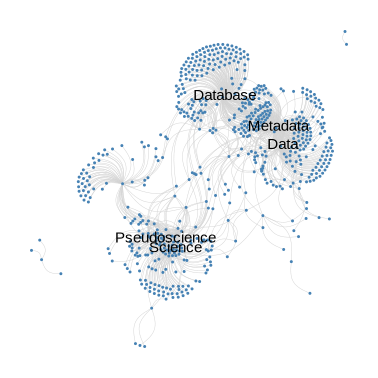

In [6]:
using GraphPlot, Plots, Compose, Cairo, Fontconfig

c = sortperm(d, rev = true)[1:5]
labels = ["" for v in V]
node_names = [data[v].name for v in V]
labels[c] = node_names[c]
layout = spring_layout(G; C=5)
P1 = gplot(G, layout...;
        linetype="curve", 
        nodelabel=labels,
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)
draw(PNG(joinpath(dirname(pwd()), "img", environmentName, "graph_visualisation.png"), 16cm, 16cm), P1)
P1

---
---
# The Laplace matrix

In [7]:
n = length(d)
L = zeros(n, n)
for i in 1:n
    for j in 1:n
        if i == j
            L[i,j] = 1
        elseif A[i,j] == 1
            L[i,j] = - 1 / sqrt(d[i] * d[j])
        end
    end
end
L

636×636 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

The eigenvalues of $L$ are called the spectrum and its plot looks like this:

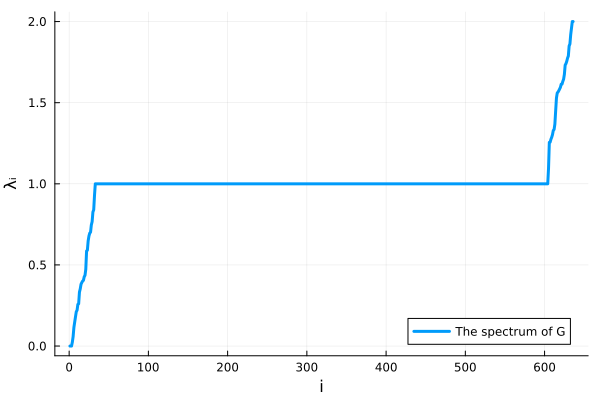

In [8]:
using LinearAlgebra

E = eigen(L)
λ = E.values
P2 = plot(λ, label = "The spectrum of G", 
             legend = :bottomright,
             linewidth = 3,
             xlab = "i",
             ylab = "λᵢ")
savefig(P2, joinpath(dirname(pwd()), "img", environmentName, "spectrum_of_G.png"))
P2

The number of components of $G$ is equal to $\text{dim}(\text{ker}(L)) = \text{dim}(\text{Eig}_0)$.

In [9]:
n_components = count(λ .< 1e-14)

3

In [10]:
C = connected_components(G)

3-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  627, 628, 629, 630, 631, 632, 633, 634, 635, 636]
 [107, 617]
 [274, 490, 593, 594]

In [11]:
sum(λ), n

(635.9999999999999, 636)

---
# Analysing the largest component

In [12]:
k = findmax(length.(C))
I = C[k[2]];
H = Graph(A[I, I])

{630, 1105} undirected simple Int64 graph

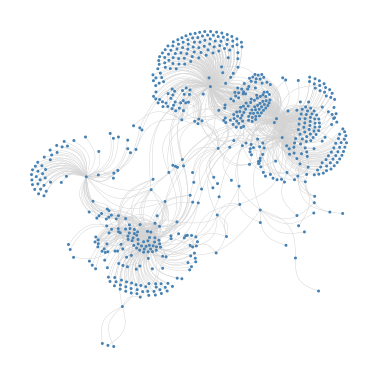

In [13]:
layout_H = (layout[1][I], layout[2][I])
P3 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)
draw(PNG(joinpath(dirname(pwd()), "img", environmentName, "graph_H_visualisation.png"), 16cm, 16cm), P3)
P3

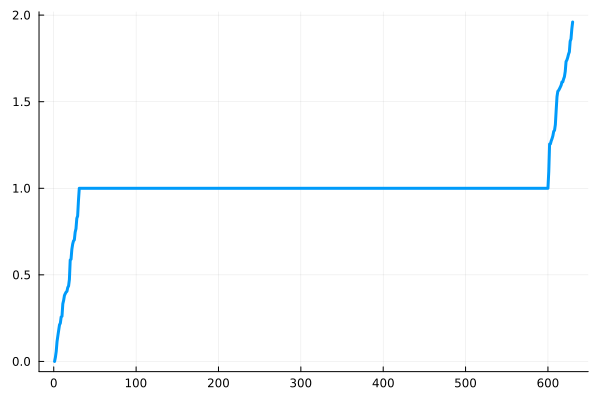

In [14]:
L_H = L[I,I]
E_H = eigen(L_H)
λ_H = E_H.values
P4 = plot(λ_H, legend = false, linewidth = 3)
savefig(P4, joinpath(dirname(pwd()), "img", environmentName, "spectrum_of_H.png"))
P4

Let $w$ be the eigenvector to eigenvalue $\lambda_G$. We are gonna plot the graph and color the nodes red if their corresponding entry in $w$ is positive, blue if the entry is negative, and yellow if the entry is 0. This induces a clustering into two partitions.

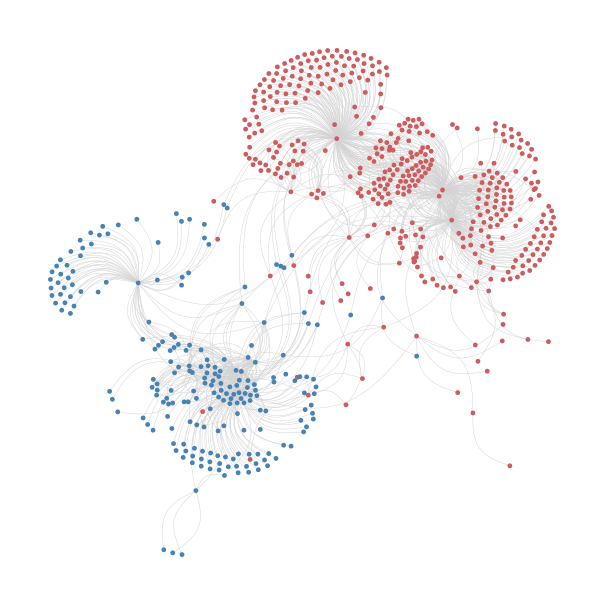

In [ ]:
using Images, IJulia

w = E_H.vectors[:,2]
cols = []
for wᵢ in w
    if abs(wᵢ) > 1e-12 
        if wᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
layout= x -> spring_layout(x; C=5)
P5 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = cols
)
# save the image to disk and load it from disk to dodge some display issues in VSCode
imagePath = joinpath(dirname(pwd()), "img", environmentName, "clustering_of_H_by_smallest_lambda.png")
draw(PNG(imagePath, 16cm, 16cm), P5)
IJulia.display(load(imagePath))

Lets have a look at the node-labels of their respective clusters:

In [16]:
[entry.name for entry in data[I][w .> 0]]

417-element Vector{String}:
 "Data_science"
 "Data_acquisition"
 "Data_ecosystem"
 "Data_archaeology"
 "Data_cooperative"
 "Data_editing"
 "Data_cleansing"
 "Data_anonymization"
 "Data_curation"
 "Data_format_management"
 ⋮
 "MD_Data"
 "Database_dump"
 "Firebird_(database_server)"
 "Cloud_Data_Management_Interface"
 "Dummy_data"
 "Pool_(computer_science)"
 "Node_(computer_science)"
 "Bento_(database)"
 "Protocol_data_unit"

In [17]:
[entry.name for entry in data[I][w .< 0]]

213-element Vector{String}:
 "Computational_science"
 "Computer_science"
 "Bachelor_of_Science"
 "American_Academy_of_Arts_and_Sciences"
 "Political_science"
 "Formal_science"
 "Natural_science"
 "Neuroscience"
 "Computational_neuroscience"
 "Science"
 ⋮
 "List_of_philosophers_of_science"
 "French_Institute_for_Research_in_Computer_Science_and_Automation"
 "Data_manipulation_language"
 "Statistical_database"
 "Data_Act_(European_Union)"
 "Hitachi_Data_Systems"
 "Global_Research_Identifier_Database"
 "Datasheets"
 "Data_conferencing"

Similarly we can partition the node set by using the eigenvector to eigenvalue $\lambda_{|V(H)|-1}$.

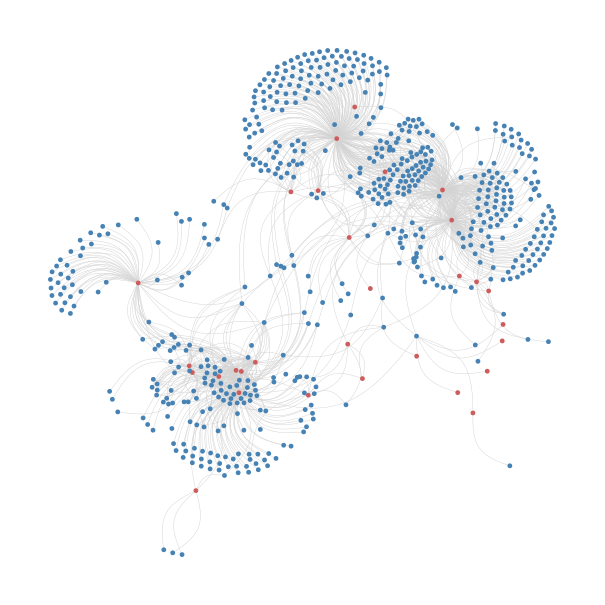

In [ ]:
using IJulia, Images

u = E_H.vectors[:,end]
cols = []
for uᵢ in u
    if abs(uᵢ) > 1e-12 
        if uᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
P6 = gplot(H, layout_H...;
        linetype="curve",
        nodefillc = cols
)
# save the image to disk and load it from disk to dodge some display issues in VSCode
imagePath = joinpath(dirname(pwd()), "img", environmentName, "clustering_of_H_by_largest_lambda.png")
draw(PNG(imagePath, 16cm, 16cm), P6)
IJulia.display(load(imagePath))

In [19]:
[entry.name for entry in data[I][u .> 1e-12]]

30-element Vector{String}:
 "Data"
 "Metadata"
 "Neuroscience"
 "Datafication"
 "Science"
 "Sciences"
 "Database"
 "Databases"
 "Datanet"
 "DataONE"
 ⋮
 "Nutritional_science"
 "Outline_of_physical_science"
 "Aesthetics_of_science"
 "Feminist_technoscience"
 "XML_Metadata_Interchange"
 "Navigational_database"
 "Database_server"
 "Framing_(social_sciences)"
 "Global_Research_Identifier_Database"

In [20]:
[entry.name for entry in data[I][u .< 1e-12]]

600-element Vector{String}:
 "Data_science"
 "Data_acquisition"
 "Data_ecosystem"
 "Data_archaeology"
 "Data_cooperative"
 "Data_editing"
 "Computational_science"
 "Data_cleansing"
 "Data_anonymization"
 "Data_curation"
 ⋮
 "Cloud_Data_Management_Interface"
 "Dummy_data"
 "Pool_(computer_science)"
 "Node_(computer_science)"
 "Bento_(database)"
 "Protocol_data_unit"
 "Hitachi_Data_Systems"
 "Datasheets"
 "Data_conferencing"